<h1> Training Notebook for Model 1 </h1>

In [59]:
# Loading libraries
import numpy as np
import json
import pandas as pd
from ast import literal_eval
import librosa
import keras
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [60]:
# please set this variable to where you cloned the git repo "MLAudioClassifier"

filepath = "/Users/Gilby/Projects/MLAudioClassifier"
os.chdir(filepath)

<h1> Loading the training set of MFCC features from .json file </h1>

In [61]:
# Attempt to locate the training MFCC JSON file robustly
# Preferred / expected location based on project docs: data/mfcc_train_data.json
# Fallbacks: project root (mfcc_train_data.json), parent dir, or explicit override

from pathlib import Path

POSSIBLE_PATHS = [
    Path('data/mfcc_train_data.json'),          # standard location
    Path('../data/mfcc_train_data.json'),       # if cwd is notebooks/
    Path('mfcc_train_data.json'),               # root fallback
    Path('../mfcc_train_data.json')             # legacy placement
]

found_path = None
for p in POSSIBLE_PATHS:
    if p.exists():
        found_path = p
        break

if found_path is None:
    print('❌ Could not find mfcc_train_data.json in expected locations:')
    for p in POSSIBLE_PATHS:
        print(f' - {p}')
    print('\n➡️  Please run the MFCC_Feature_Extractor notebook first to generate the file.')
    raise FileNotFoundError('mfcc_train_data.json not found')
else:
    print(f'✅ Using training MFCC file: {found_path}')

with open(found_path, 'r') as fp:
    data = json.load(fp)

# Expect keys: mfcc (list/array), label (list/array)
if not all(k in data for k in ('mfcc', 'label')):
    raise KeyError('Expected keys "mfcc" and "label" not found in JSON file')

X = np.array(data['mfcc'])
y = np.array(data['label'])
print('Loaded feature matrix shape:', X.shape)
print('Loaded label vector length:', len(y))

✅ Using training MFCC file: data/mfcc_train_data.json
Loaded feature matrix shape: (11659, 40, 98)
Loaded label vector length: 11659
Loaded feature matrix shape: (11659, 40, 98)
Loaded label vector length: 11659


In [62]:
# Diagnose and normalize label indices so they are contiguous starting at 0
import numpy as np
unique_labels = np.unique(y)
print(f"Raw label values ({len(unique_labels)} classes detected): {unique_labels[:20]}{' ...' if len(unique_labels)>20 else ''}")
print(f"Max label value: {y.max()}")

# If labels are not 0..N-1 contiguous, remap them
needs_remap = (y.max() != len(unique_labels)-1) or (unique_labels != np.arange(len(unique_labels))).any()
if needs_remap:
    print("⚠️  Non-contiguous or gapped label indices detected. Remapping to 0..N-1.")
    label_mapping = {old:i for i, old in enumerate(sorted(unique_labels))}
    y = np.array([label_mapping[v] for v in y])
    unique_labels = np.unique(y)
    print("✅ Remap complete. New label set:", unique_labels)
    print("Mapping (old -> new):", label_mapping)
else:
    print("✅ Labels already contiguous 0..N-1. No remap needed.")

num_classes = len(unique_labels)
print("Inferred number of classes:", num_classes)

Raw label values (34 classes detected): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ...
Max label value: 33
✅ Labels already contiguous 0..N-1. No remap needed.
Inferred number of classes: 34


In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [64]:
# this should be 40 x 98
print(X.shape[1], X.shape[2])

40 98


<h1> Building the CNN </h1>

In [65]:
model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),

        # output layer (num_classes inferred dynamically)
        keras.layers.Dense(num_classes, activation='softmax')
    ])

/Users/Gilby/Projects/MLAudioClassifier/.venv/lib/python3.13/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
optimiser = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("Model compiled with:")
print(f" - Learning rate: {optimiser.learning_rate.numpy()}")
print(f" - Output classes: {num_classes}")

Model compiled with:
 - Learning rate: 0.0005000000237487257
 - Output classes: 34


In [67]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,007,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176,162 (8.30 MB)

 Trainable params: 2,176,162 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

<h1> Training the CNN on MFCC features </h1>
<p> And saving it to an .keras file so we can use it later. I will include some plots at the bottom to see how the training went. </p>

In [68]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# ---- Fixed save section (avoid read-only root path) ----
import json
save_dir = os.path.join(filepath, 'models')
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model1.keras')
history_path = os.path.join(save_dir, 'model1_history.json')

model.save(model_path)

# Save training history
with open(history_path, 'w') as f:
    json.dump({k: [float(vv) for vv in vals] for k, vals in history.history.items()}, f, indent=2)

print(f"✅ Model saved to {model_path}")
print(f"✅ History saved to {history_path}")

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4523 - loss: 2.0096 - val_accuracy: 0.5592 - val_loss: 1.5884 - learning_rate: 5.0000e-04
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4523 - loss: 2.0096 - val_accuracy: 0.5592 - val_loss: 1.5884 - learning_rate: 5.0000e-04
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5627 - loss: 1.5723 - val_accuracy: 0.6128 - val_loss: 1.4033 - learning_rate: 5.0000e-04
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5627 - loss: 1.5723 - val_accuracy: 0.6128 - val_loss: 1.4033 - learning_rate: 5.0000e-04
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6013 - loss: 1.4187 - val_accuracy: 0.6256 - val_loss: 1.3287 - learning_rate: 5.0000e-04
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6013 - loss: 1.4187 - val_accuracy: 0.6256 - val_loss: 1.3287 - learning_rate: 5.0000e-04
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 

✅ Model saved to /Users/Gilby/Projects/MLAudioClassifier/models/model1.keras
✅ History saved to /Users/Gilby/Projects/MLAudioClassifier/models/model1_history.json


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


OSError: [Errno 30] Read-only file system: '/results'

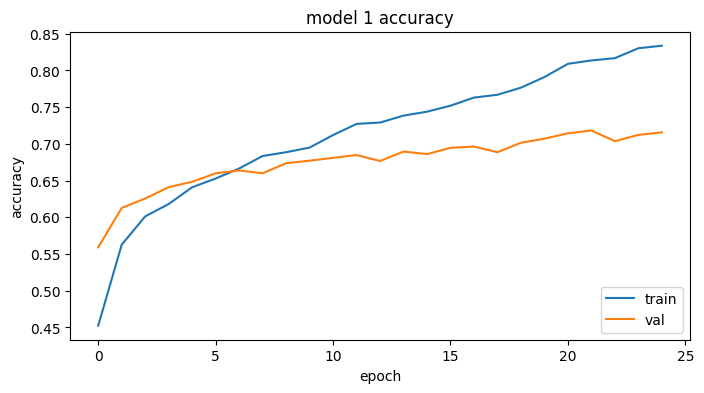

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
# Use project-local results directory instead of root (read-only) path
results_dir = os.path.join(filepath, 'results')
os.makedirs(results_dir, exist_ok=True)
plt.savefig(os.path.join(results_dir, 'accuracy.png'), dpi=120, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(os.path.join(results_dir, 'loss.png'), dpi=120, bbox_inches='tight')
plt.show()

print(f"✅ Plots saved to {results_dir}")